In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip list --format=freeze > requirements.txt

In [2]:
df = pd.read_csv('ner_dataset.csv', encoding='latin1')
df = df.fillna(method='ffill')
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
df.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [4]:
words = list(set(df['Word'].values))
num_words = len(words)
tags = list(set(df['Tag'].values))#iob2 tags 
num_tags = len(tags)
num_words, num_tags

(35178, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [6]:
# Retrive sentences and tags from the dataset
class SentenceGetter(object):
        
        def __init__(self, data):
            self.n_sent = 1
            self.data = data
            self.empty = False
            agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                            s["POS"].values.tolist(),
                                                            s["Tag"].values.tolist())]
            self.grouped = self.data.groupby("Sentence #").apply(agg_func)
            self.sentences = [s for s in self.grouped]

        def get_next(self):
            try:
                s = self.grouped["Sentence: {}".format(self.n_sent)]
                self.n_sent += 1
                return s
            except:
                return None

getter = SentenceGetter(df)
sentences = getter.sentences

In [7]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [8]:
word2idx = {w: i for i, w in enumerate(words)}
#print (word2idx)
tag2idx = {t: i for i, t in enumerate(tags)}
print(tag2idx)

{'B-art': 0, 'B-per': 1, 'I-tim': 2, 'B-gpe': 3, 'B-geo': 4, 'I-geo': 5, 'I-art': 6, 'I-per': 7, 'B-eve': 8, 'I-nat': 9, 'B-nat': 10, 'I-org': 11, 'B-tim': 12, 'I-gpe': 13, 'I-eve': 14, 'O': 15, 'B-org': 16}


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences#add numbers to the sequences to make them all be the same length. 
from tensorflow.keras.utils import to_categorical

In [10]:
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [12]:
x_train

array([[16572, 33473,  3938, ..., 35177, 35177, 35177],
       [12214, 34886, 28426, ..., 35177, 35177, 35177],
       [31147,  7966, 34777, ..., 35177, 35177, 35177],
       ...,
       [ 9738, 17237,  4205, ..., 35177, 35177, 35177],
       [35157,  8529, 12517, ..., 35177, 35177, 35177],
       [ 1530, 23884, 29637, ..., 35177, 35177, 35177]], dtype=int32)

In [13]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [14]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

2022-12-08 15:55:37.617447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:55:37.769513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:55:37.770372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 15:55:37.772027: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,117
Trainable params: 1,883,117
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#pip install livelossplot
from tensorflow.keras.callbacks import  EarlyStopping
#from livelossplot.tf_keras import PlotLossesCallback

In [16]:
#PlotLossesCallback(),
import numpy as np
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
    callbacks = callbacks
)

2022-12-08 15:55:40.996927: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
1080/1080 [==============================] - 384s 351ms/step - loss: 0.1908 - accuracy: 0.9565 - val_loss: 0.0689 - val_accuracy: 0.9803
Epoch 2/3
1080/1080 [==============================] - 377s 349ms/step - loss: 0.0534 - accuracy: 0.9843 - val_loss: 0.0509 - val_accuracy: 0.9844
Epoch 3/3
1080/1080 [==============================] - 377s 349ms/step - loss: 0.0378 - accuracy: 0.9885 - val_loss: 0.0474 - val_accuracy: 0.9856


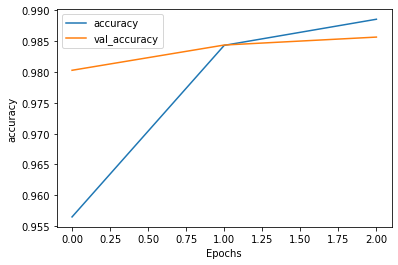

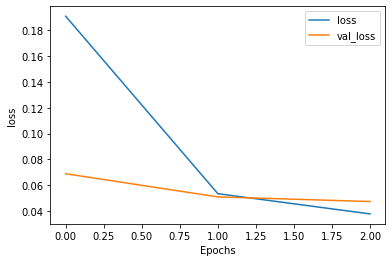

In [21]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [22]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 4s 25ms/step - loss: 0.0490 - accuracy: 0.9853


[0.049042489379644394, 0.9853085875511169]

In [23]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
restaurants    O	O
letting        B-tim	B-tim
double         I-tim	I-tim
tendon         O	O
threat         O	O
Eide           O	O
possess        O	O
Mehsud         O	O
overcome       O	O
Amazon         B-geo	B-geo
Ler            I-geo	O
tendon         O	O
me             O	O
incapacitated  O	O
650            O	O
conservative   O	O
Hafez          O	O
insulting      O	O
possess        O	O
Txeroki        O	O
explosives-filledO	O
Peacock        O	O
informant      O	O
cooler         O	O
Peacock        O	O
flesh          O	O
threat         O	O
Due            O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O
La             O	O